In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
angles = np.array([20., 60., -30., -35.])
freqs = np.array([1/2, 1/3, 1/5, 1/10])
thetas = np.array(angles) / 180 * np.pi       
w = np.array(freqs)*2*np.pi     
N = 200                         
M = 10                          
D = np.size(thetas)                     
wavelen = 150                           
d = wavelen / 2                         
var = 0.10  

In [ ]:
def generate_data(M, N, d, wavelen, angles, freqs, var=0.01):
    thetas = np.array(angles) / 180 * np.pi
    w = np.array(freqs)*2*np.pi 
    D = np.size(thetas)
    A = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
    S = 2 * np.exp(1j * (np.kron(w, np.arange(N)).reshape((D, N))))
    Noise = var * np.random.randn(M, N)
    X = np.dot(A, S) + Noise
    return X

In [ ]:
def musicDOA(X, M, d, wavelen, thetas, L=0, resscale="log", corr="false", ee="false"):
    D = np.size(thetas)
    K=M-L
    # Make sure we have more receivers than input signals
    assert(M > D)
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    # 
    if corr!="false":
      J = np.flip(np.eye(M), axis=1)
      R = R + np.dot(J, np.dot(R.conj(), J))

    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(L+1)]  
    En = eig_vect[:,ids]
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)
   
    # Size = future size of Pmusic
    Size = np.size(peak_search_range)

    m=np.arange(M)
    a=np.zeros((M,L+1))*1j
    # 
    #a = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(peak_search_range * np.pi /180)).reshape(M, L))
    # Pmusic = a(peak_search_range)' * En * En' * a(peak_search_range)
    Pmusic = np.zeros(Size)
    for i in range(Size):
        a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[:K])
        a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[K:]))
        Pmusic[i] = 1/abs(np.linalg.det(np.dot(a.conj().T, np.dot(Ren, a))))
    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    

    if ee!="false":
      x=peak_search_range[np.argmax(Pmusic)]
      a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[:K])
      a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[K:]))
      n, v = np.linalg.eig(np.dot(a.conj().T, np.dot(Ren, a)))
      error = v[:, np.argsort(np.absolute(n))[0]]
      error = error / error[0]
      return Pmusic, peak_search_range, error
    return Pmusic, peak_search_range

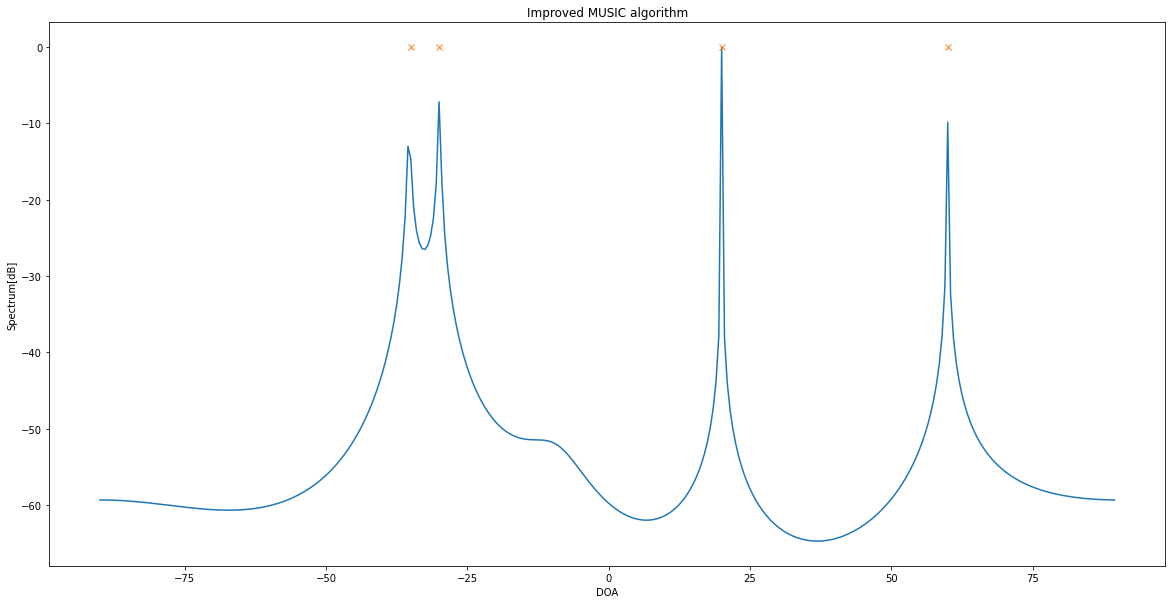

actual amplitude error:
1.1153
0.9092
1.0356
1.0542
estimated:
1.1165
0.9074
1.0313
1.0500

 actual phase error:
0.0632
-0.4020
-1.0247
-1.4840
estimated:
0.0627
-0.3995
-1.0260
-1.4895


In [ ]:
L=4
y = generate_data(M,N,d,wavelen,angles,freqs,var)

phase_error = np.random.normal(0, 1, L)
amp_error = np.random.normal(1, var, L)

y[-L:, :] = y[-L:, :] * np.tile(amp_error, (N, 1)).T * np.tile(np.exp(1j*phase_error), (N, 1)).T


Pmusic, peak_search_range, error  = musicDOA(y,M,d,wavelen,thetas,L, ee="true")
plt.figure(figsize=(20,10))
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Improved MUSIC algorithm")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()


amp_error_estimation = np.absolute(error)
phase_error_estimation = np.angle(error)

print('actual amplitude error:')
for x in amp_error.tolist():print('%.4f' % x)

print('estimated:')
for x in amp_error_estimation.tolist()[1:]:print('%.4f' % x)

print('\n actual phase error:')
for x in phase_error.tolist():print('%.4f' % x)

print('estimated:')
for x in phase_error_estimation.tolist()[1:]:print('%.4f' % x)

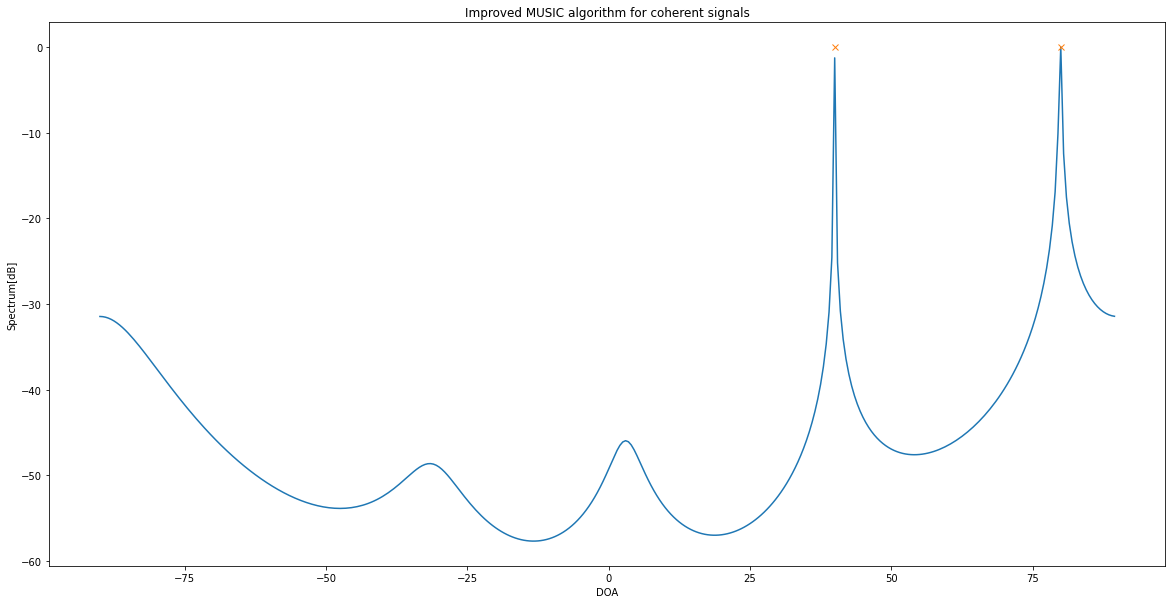

In [ ]:
plt.figure(figsize=(20,10))
a=np.array([40, 80])
f=np.array([1/4, 1/4]) * np.pi 
X = generate_data(M,N,d,wavelen,a,f,var)
Pmusic, peak_search_range = musicDOA(X,M,d,wavelen,thetas,L=5, corr="true")
plt.plot(peak_search_range, Pmusic)
plt.plot(a,np.zeros(a.size),"x")
plt.title("Improved MUSIC algorithm for coherent signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()